# 🐶 Stanford Dogs - Multi-model Training & Comparison
Train multiple deep learning models on the Stanford Dogs dataset and compare their performance.

In [1]:
%pip install tensorflow tensorflow-datasets matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    as_supervised=False
)

NUM_CLASSES = ds_info.features['label'].num_classes

def preprocess(data):
    image = tf.image.resize(data['image'], (IMG_SIZE, IMG_SIZE))
    label = tf.one_hot(data['label'], NUM_CLASSES)
    return image, label

ds_train = (ds_train.map(preprocess, num_parallel_calls=AUTOTUNE)
                   .shuffle(1000)
                   .batch(BATCH_SIZE)
                   .prefetch(AUTOTUNE))

ds_test = (ds_test.map(preprocess, num_parallel_calls=AUTOTUNE)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTOTUNE))


In [3]:

def create_simple_cnn():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

def create_resnet50():
    base = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base.trainable = False
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

def create_mobilenet():
    base = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base.trainable = False
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = base(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)


In [4]:
models = {
    "SimpleCNN": create_simple_cnn(),
    "ResNet50": create_resnet50(),
    "MobileNetV2": create_mobilenet()
}

results = {}

for name, model in models.items():
    print(f"\nTraining model: {name}")
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(ds_train, epochs=5, validation_data=ds_test)
    test_loss, test_acc = model.evaluate(ds_test)
    results[name] = test_acc

    # Lưu mô hình dưới định dạng .keras
    model.save(f'model_{name}.keras')
    print(f"✅ Đã lưu mô hình: model_{name}.keras")



Training model: SimpleCNN
Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 202s 527ms/step - accuracy: 0.0095 - loss: 7.8561 - val_accuracy: 0.0112 - val_loss: 4.7858
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 202s 536ms/step - accuracy: 0.0097 - loss: 4.7796 - val_accuracy: 0.0106 - val_loss: 4.7798
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 194s 515ms/step - accuracy: 0.0104 - loss: 4.7592 - val_accuracy: 0.0133 - val_loss: 4.7538
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 219s 582ms/step - accuracy: 0.0162 - loss: 4.7359 - val_accuracy: 0.0177 - val_loss: 4.7249
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 222s 589ms/step - accuracy: 0.0195 - loss: 4.7099 - val_accuracy: 0.0178 - val_loss: 4.7232
269/269 ━━━━━━━━━━━━━━━━━━━━ 42s 156ms/step - accuracy: 0.0178 - loss: 4.7320
✅ Đã lưu mô hình: model_SimpleCNN.keras

Training model: ResNet50
Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1342s 3s/step - accuracy: 0.4374 - loss: 2.5944 - val_accuracy: 0.7399 - val_loss: 0.8782
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1029s 

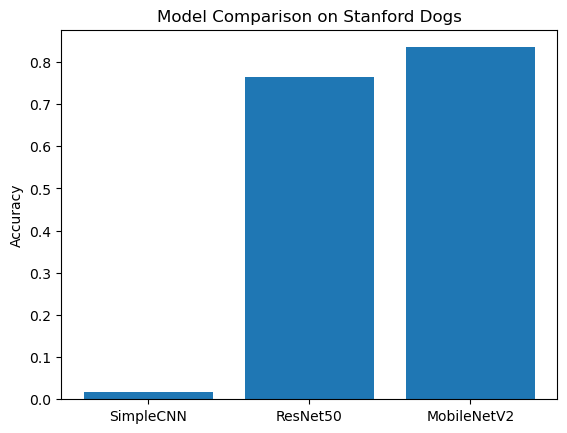

In [15]:

# Plot comparison
plt.bar(results.keys(), results.values())
plt.ylabel("Accuracy")
plt.title("Model Comparison on Stanford Dogs")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


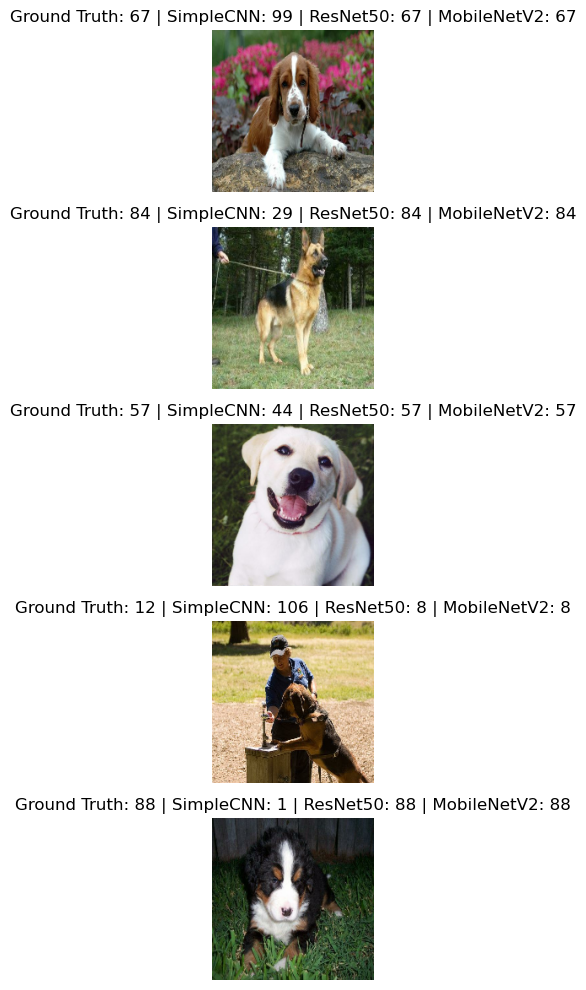

In [33]:
import numpy as np

# Lấy một batch từ test set
for batch_images, batch_labels in ds_test_processed.take(1):

    images = batch_images.numpy()
    true_labels = tf.argmax(batch_labels, axis=1).numpy()
    break

# Dự đoán bằng từng mô hình
preds = {}
for name, model in models.items():
    predictions = model.predict(images)
    preds[name] = tf.argmax(predictions, axis=1).numpy()

# Hiển thị ảnh và dự đoán từ các mô hình
plt.figure(figsize=(15, 10))
for i in range(5):  # hiển thị 5 ảnh đầu tiên
    plt.subplot(5, 1, i+1)
    plt.imshow(images[i].astype("uint8"))
    title = f"Ground Truth: {true_labels[i]}"
    for name in preds:
        title += f" | {name}: {preds[name][i]}"
    plt.title(title)
    plt.axis("off")

plt.tight_layout()
plt.show()


C:\Users\daoth\AppData\Local\Temp\ipykernel_23040\2851650491.py:19: UserWarning: Glyph 128054 (\N{DOG FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\daoth\AppData\Local\Temp\ipykernel_23040\2851650491.py:19: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\daoth\AppData\Local\Temp\ipykernel_23040\2851650491.py:19: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


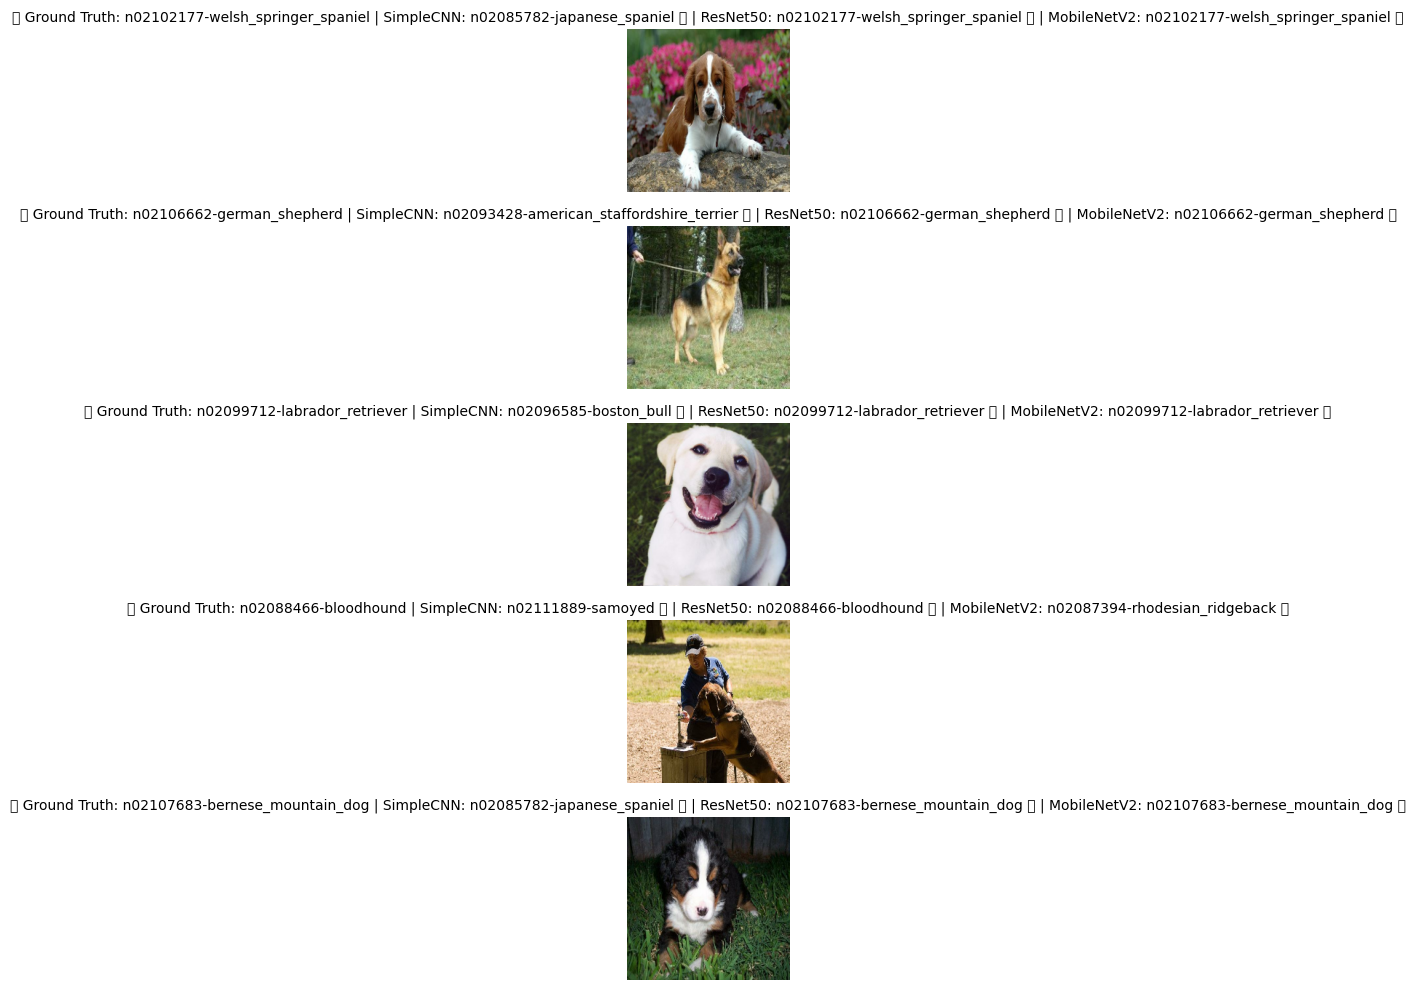

In [19]:
label_map = ds_info.features['label'].int2str

plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(5, 1, i+1)
    plt.imshow(images[i].astype("uint8"))
    
    true_name = label_map(true_labels[i])
    title = "🐶 Ground Truth: " + true_name
    
    for name in preds:
        pred_name = label_map(preds[name][i])
        correct = "✅" if preds[name][i] == true_labels[i] else "❌"
        title += f" | {name}: {pred_name} {correct}"
    
    plt.title(title, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [21]:
# --- BƯỚC 1: CÀI ĐẶT VÀ TẢI DỮ LIỆU ---

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# --- Tối ưu hóa thông số để chạy nhanh hơn ---
IMG_SIZE = 192      # Giảm kích thước ảnh để tăng tốc
BATCH_SIZE = 16     # Tăng batch size để tận dụng GPU
# Lưu ý: Nếu bạn gặp lỗi "Out of Memory", hãy giảm BATCH_SIZE xuống 32

# Tải bộ dữ liệu (sẽ dùng cache bạn đã tải về)
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

# Lấy thông tin cần thiết từ ds_info
NUM_CLASSES = ds_info.features['label'].num_classes
NUM_TRAIN_EXAMPLES = ds_info.splits['train'].num_examples

print(f"Tải dữ liệu hoàn tất. Số giống chó: {NUM_CLASSES}, Số ảnh huấn luyện: {NUM_TRAIN_EXAMPLES}")

Tải dữ liệu hoàn tất. Số giống chó: 120, Số ảnh huấn luyện: 12000


In [23]:
# --- BƯỚC 2: TẠO PIPELINE DỮ LIỆU TỐI ƯU ---

# Hàm tiền xử lý
def preprocess_image(data):
    image = data['image']
    label = data['label']
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

# Lớp Data Augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(0.1),
])

# Tạo pipeline cho tập TRAIN
ds_train_processed = (
    ds_train
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .shuffle(NUM_TRAIN_EXAMPLES)
    .map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Tạo pipeline cho tập TEST
ds_test_processed = (
    ds_test
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

print("Pipeline dữ liệu đã sẵn sàng.")

Pipeline dữ liệu đã sẵn sàng.


In [25]:
# --- BƯỚC 3: XÂY DỰNG VÀ BIÊN DỊCH MÔ HÌNH ---

# Tải mô hình nền
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Đóng băng mô hình nền
base_model.trainable = False

# Xây dựng mô hình hoàn chỉnh
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# EfficientNetV2 có lớp preprocess_input tích hợp sẵn, ta có thể gọi nó như một layer
x = tf.keras.applications.efficientnet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

# Biên dịch mô hình cho Giai đoạn 1
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Mô hình đã được xây dựng và biên dịch cho Giai đoạn 1.")
model.summary()

Mô hình đã được xây dựng và biên dịch cho Giai đoạn 1.


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 192, 192, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 6, 6, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 120)            │       153,720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,073,032 (23.17 MB)

 Trainable params: 153,720 (600.47 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
# --- BƯỚC 4: HUẤN LUYỆN (ĐÃ CHỈNH SỬA ĐỂ TỐI ƯU BỘ NHỚ) ---

# --- Giai đoạn 1: Feature Extraction ---
# Ở giai đoạn này, base_model.trainable vẫn đang là False

print("--- Bắt đầu Giai đoạn 1: Feature Extraction ---")

# Biên dịch mô hình với learning rate ban đầu
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

epochs_fe = 10
history_fe = model.fit(
    ds_train_processed,
    epochs=epochs_fe,
    validation_data=ds_test_processed
)

print("\n--- Hoàn thành Giai đoạn 1 ---")


# --- Giai đoạn 2: Fine-tuning ---
print("\n--- Bắt đầu Giai đoạn 2: Fine-tuning (chỉ tinh chỉnh các lớp cuối) ---")

# Mở băng mô hình nền
base_model.trainable = True

# Đóng băng tất cả các lớp, trừ 30 lớp cuối cùng
fine_tune_at = -30
print(f"Mở băng các lớp từ lớp thứ {fine_tune_at} trở đi để fine-tuning.")

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Giữ các lớp BatchNorm ở chế độ inference để ổn định quá trình học
# và tránh phá vỡ các đặc trưng đã học.
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Biên dịch lại mô hình với learning rate RẤT NHỎ
# Điều này cực kỳ quan trọng để tránh phá hỏng các trọng số đã học
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # learning rate 0.00001
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# In lại cấu trúc để xem sự thay đổi của "Trainable params"
print("\nCấu trúc mô hình sau khi mở băng một phần:")
model.summary()

# Tiếp tục huấn luyện
epochs_ft = 10 # Huấn luyện thêm 10 epochs cho fine-tuning
total_epochs = epochs_fe + epochs_ft

history_ft = model.fit(
    ds_train_processed,
    epochs=total_epochs,
    initial_epoch=history_fe.epoch[-1], # Bắt đầu từ epoch cuối của giai đoạn trước
    validation_data=ds_test_processed
)

print("\n--- Huấn luyện hoàn tất! ---")

--- Bắt đầu Giai đoạn 1: Feature Extraction ---
Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 158s 195ms/step - accuracy: 0.4628 - loss: 2.6189 - val_accuracy: 0.8444 - val_loss: 0.5770
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 333s 443ms/step - accuracy: 0.7716 - loss: 0.8067 - val_accuracy: 0.8523 - val_loss: 0.4885
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 270s 359ms/step - accuracy: 0.7994 - loss: 0.6824 - val_accuracy: 0.8572 - val_loss: 0.4650
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 144s 192ms/step - accuracy: 0.8173 - loss: 0.5869 - val_accuracy: 0.8542 - val_loss: 0.4642
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 150s 201ms/step - accuracy: 0.8292 - loss: 0.5421 - val_accuracy: 0.8599 - val_loss: 0.4504
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 152s 202ms/step - accuracy: 0.8400 - loss: 0.5051 - val_accuracy: 0.8604 - val_loss: 0.4504
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 147s 196ms/step - accuracy: 0.8526 - loss: 0.4591 - val_accuracy: 0.8575 - val_loss: 0.4606
Epoch 8/10
750/750 ━━━━━━━━━

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 192, 192, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 6, 6, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 120)            │       153,720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,073,032 (23.17 MB)

 Trainable params: 1,307,352 (4.99 MB)

 Non-trainable params: 4,765,680 (18.18 MB)

Epoch 10/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 449s 563ms/step - accuracy: 0.8795 - loss: 0.3771 - val_accuracy: 0.8572 - val_loss: 0.4689
Epoch 11/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 213s 283ms/step - accuracy: 0.8878 - loss: 0.3425 - val_accuracy: 0.8550 - val_loss: 0.4734
Epoch 12/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 154s 205ms/step - accuracy: 0.8881 - loss: 0.3477 - val_accuracy: 0.8552 - val_loss: 0.4754
Epoch 13/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 158s 210ms/step - accuracy: 0.8925 - loss: 0.3332 - val_accuracy: 0.8555 - val_loss: 0.4773
Epoch 14/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 155s 207ms/step - accuracy: 0.8952 - loss: 0.3305 - val_accuracy: 0.8554 - val_loss: 0.4788
Epoch 15/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 161s 214ms/step - accuracy: 0.9027 - loss: 0.3061 - val_accuracy: 0.8547 - val_loss: 0.4819
Epoch 16/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 167s 222ms/step - accuracy: 0.8938 - loss: 0.3198 - val_accuracy: 0.8548 - val_loss: 0.4812
Epoch 17/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 218s 291ms/step - accuracy: 

In [31]:
# --- BƯỚC 5: TRỰC QUAN HÓA KẾT QUẢ ---

# Kết hợp history từ 2 giai đoạn
acc = history_fe.history['accuracy'] + history_ft.history['accuracy']
val_acc = history_fe.history['val_accuracy'] + history_ft.history['val_accuracy']
loss = history_fe.history['loss'] + history_ft.history['loss']
val_loss = history_fe.history['val_loss'] + history_ft.history['val_loss']

# Vẽ biểu đồ
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# Vẽ đường phân cách giữa 2 giai đoạn
plt.axvline(epochs_fe - 1, linestyle='--', color='r', label='Bắt đầu Fine-tuning')
plt.title('Độ chính xác qua các Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# Vẽ đường phân cách giữa 2 giai đoạn
plt.axvline(epochs_fe - 1, linestyle='--', color='r', label='Bắt đầu Fine-tuning')
plt.title('Hàm mất mát qua các Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

NameError: name 'history_fe' is not defined

In [29]:
# --- BƯỚC 6: ĐÁNH GIÁ CUỐI CÙNG ---

print("\nĐang thực hiện đánh giá cuối cùng trên tập test...")
final_loss, final_accuracy = model.evaluate(ds_test_processed)

print("-" * 30)
print(f"Final Test Loss: {final_loss:.4f}")
print(f"Final Test Accuracy: {final_accuracy*100:.2f}%")
print("-" * 30)


Đang thực hiện đánh giá cuối cùng trên tập test...
537/537 ━━━━━━━━━━━━━━━━━━━━ 66s 114ms/step - accuracy: 0.0071 - loss: 4.8531
------------------------------
Final Test Loss: 4.8534
Final Test Accuracy: 0.77%
------------------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


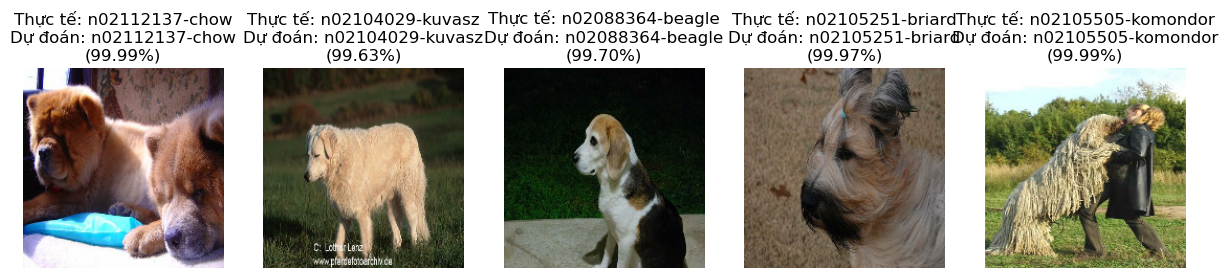

In [ ]:
# --- BƯỚC 7: DỰ ĐOÁN THỰC TẾ ---

# Lấy một lô dữ liệu từ tập test
image_batch, label_batch = next(iter(ds_test_processed))

# Dự đoán
predictions = model.predict(image_batch)

# Lấy tên các lớp
class_names = np.array(ds_info.features['label'].names)

# Hiển thị kết quả cho 5 ảnh đầu tiên trong lô
plt.figure(figsize=(15, 15))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)

    # Ảnh đầu vào cho mô hình là [-1, 1], cần chuyển về [0, 1] để hiển thị
    # Hoặc nếu bạn dùng preprocess_input thì nó đã được chuẩn hóa, không cần rescale
    # Để đơn giản, ta sẽ lấy lại ảnh gốc từ bộ dữ liệu gốc để hiển thị
    original_image = image_batch[i] / 255.0 # Rescale về [0,1] để hiển thị
    plt.imshow(original_image)

    predicted_class_index = np.argmax(predictions[i])
    actual_class_index = np.argmax(label_batch[i])

    predicted_class_name = class_names[predicted_class_index]
    actual_class_name = class_names[actual_class_index]

    prediction_confidence = np.max(predictions[i]) * 100

    plt.title(f"Thực tế: {actual_class_name}\nDự đoán: {predicted_class_name}\n({prediction_confidence:.2f}%)")
    plt.axis("off")
plt.show()

In [ ]:
# --- BƯỚC 8: LƯU MÔ HÌNH ---

model.save('stanford_dogs_efficientnet_final.keras')
print("\nĐã lưu mô hình cuối cùng vào file 'stanford_dogs_efficientnet_final.keras'")


Đã lưu mô hình cuối cùng vào file 'stanford_dogs_efficientnet_final.keras'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


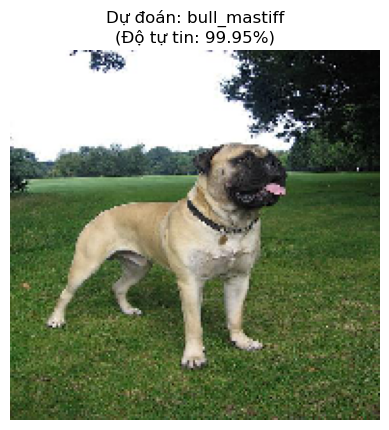

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
import numpy as np

# Đảm bảo các biến model, class_names, và IMG_SIZE đã tồn tại từ các bước trước
# Nếu không chắc, hãy chạy lại các cell định nghĩa chúng.

# --- HÀM DỰ ĐOÁN VÀ HIỂN THỊ ---
def predict_and_display_image(model_to_predict, img_path, class_names_list, img_size=192):
    """
    Hàm này nhận đầu vào là mô hình, đường dẫn ảnh, danh sách tên lớp,
    sau đó tải ảnh, tiền xử lý, dự đoán và hiển thị kết quả.
    """
    # 1. Tải và thay đổi kích thước ảnh
    img = image.load_img(img_path, target_size=(img_size, img_size))

    # 2. Chuyển ảnh thành mảng numpy
    img_array = image.img_to_array(img)

    # 3. Mở rộng chiều để tạo thành một lô (batch) chứa 1 ảnh
    # Kích thước sẽ là (1, 192, 192, 3)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    # 4. Tiền xử lý ảnh ĐÚNG THEO CÁCH MÀ MÔ HÌNH YÊU CẦU
    img_processed = preprocess_input(img_array_expanded)

    # 5. Dự đoán
    prediction = model_to_predict.predict(img_processed)

    # 6. Giải mã kết quả
    predicted_class_index = np.argmax(prediction)
    predicted_class_name = class_names_list[predicted_class_index].split('-')[1] # Tách lấy tên giống chó cho đẹp
    prediction_confidence = np.max(prediction) * 100

    # 7. Hiển thị ảnh và kết quả
    plt.imshow(img)
    plt.title(f"Dự đoán: {predicted_class_name}\n(Độ tự tin: {prediction_confidence:.2f}%)")
    plt.axis("off")
    plt.show()

# --- SỬ DỤNG HÀM ---

# !!! QUAN TRỌNG:
# 1. Đảm bảo bạn đã tải file "chó.jpg" lên Colab hoặc file này tồn tại trên máy cục bộ.
# 2. Dán đường dẫn bạn đã sao chép từ thanh file vào danh sách dưới đây.

image_paths = [
    r'C:\Users\DELL\tensorflow_datasets\downloads\stanford_dogs\image dog\Images\n02108422-bull_mastiff\n02108422_200.jpg' 
]

# Chạy dự đoán cho từng ảnh trong danh sách
for path in image_paths:
    try:
        # Gọi hàm đã được định nghĩa ở trên
        predict_and_display_image(model, path, class_names, img_size=IMG_SIZE)
    except NameError as e:
        print(f"LỖI: Biến cần thiết chưa được định nghĩa ({e}). Vui lòng chạy lại các cell ở trên.")
    except FileNotFoundError:
        print(f"LỖI: Không tìm thấy file tại đường dẫn '{path}'. Hãy kiểm tra lại tên file bạn đã tải lên.")